In [1]:
import networkx as nx
import numpy as np
import matplotlib.pyplot as plt


import collections as col
import math 

In [2]:
import sys
from importlib import reload  
sys.path.insert(0, "PATH_OF_PACKAGES")

import degree_dist as ddist
import hierarchy as hry
import graph_randomisation as g_rand
import neighborhood as neig

reload(ddist)
reload(hry)
reload(g_rand)
reload(neig)
# print(sys.path)

# Degree distributions

#### content of degree_dist.py :
* Let's calculate the degree distributions of a scale free network. ( N = 10 000, m = 3)
$$ p_k \sim k^{-\gamma}$$
* It will follow a power law function, so the logarithmic binnig comes handy in the fitting process.
* The cumulative degree distribution function is the best choice, to identify the $\gamma$ exponent.

* These aree good methods in the first steps of network analysis, however in practice there are packages sharpened to handle powerlaw function (see: https://pypi.org/project/powerlaw/) 

# Degree correlation

* It's useful to see, is there any correalation between the nodes with different degrees. One option is the degree distribution function, where we compute the average degree of the nearest neighbors of the nodes with degree k. (more about this: https://en.wikipedia.org/wiki/Assortativity)




In [3]:
G_scf = nx.barabasi_albert_graph(10000,2)

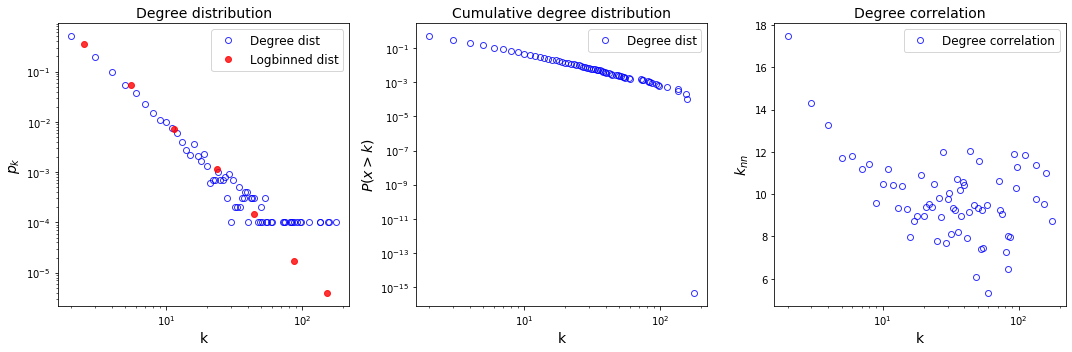

In [5]:
#degree dist:
degdist_scf = ddist.degree_dist(G_scf,direction=None)
degdist_lb_scf = ddist.degree_dist_logbinned(G_scf,base=2,direction=None)
degdist_cum_scf = ddist.cum_degree_dist(G_scf,direction=None)

#degree correlation:
degcorr_scf = ddist.degree_correlation(G_scf,direction=None)


### plots:
plt.figure(figsize=(15,5))
plt.subplot(1,3,1)
plt.plot(list(degdist_scf.keys()),list(degdist_scf.values()),'bo',markerfacecolor='none',alpha=0.8,label = 'Degree dist')
plt.plot(list(degdist_lb_scf.keys()),list(degdist_lb_scf.values()),'ro',alpha=0.8,label = 'Logbinned dist')


plt.xscale('log')
plt.yscale('log')
plt.title('Degree distribution',fontsize = 14)
plt.xlabel('k',fontsize = 14)
plt.ylabel('$p_k$',fontsize = 14)
plt.legend(fontsize = 12)

plt.subplot(1,3,2)
plt.plot(list(degdist_cum_scf.keys()),list(degdist_cum_scf.values()),'bo',markerfacecolor='none',alpha=0.8,label = 'Degree dist')


plt.xscale('log')
plt.yscale('log')
plt.title('Cumulative degree distribution',fontsize = 14)
plt.xlabel('k',fontsize = 14)
plt.ylabel('$P(x>k)$',fontsize = 14)
plt.legend(fontsize = 12)

plt.subplot(1,3,3)
plt.plot(list(degcorr_scf.keys()),list(degcorr_scf.values()),'bo',markerfacecolor='none',alpha=0.8,label = 'Degree correlation')

plt.xscale('log')
# plt.yscale('log')
plt.title('Degree correlation',fontsize = 14)
plt.xlabel('k',fontsize = 14)
plt.ylabel('$k_{nn}$',fontsize = 14)
plt.legend(fontsize = 12)

plt.tight_layout()


# Degree preserving randomisation:
#### content of graph_randomisation.py:

* If the randomisation is degree preserving, the degree distributon will remain the same.

In [10]:
%%time
G_scf_rand = g_rand.degree_preserving_randomisation(G_scf,nr_rewirings=3*G_scf.number_of_edges())

CPU times: user 20min 5s, sys: 1.47 s, total: 20min 7s
Wall time: 20min 12s


In [11]:
degdist_scf = ddist.degree_dist(G_scf,direction=None)
degdist_scf_rand = ddist.degree_dist(G_scf_rand,direction=None)
degdist_scf == degdist_scf_rand

# Reaching centrality and hierarchy:
#### content of hierarchy.py:

* There are various metrics to measure the hierarchy in a network. My solution is based on the article: <br> Mones E, Vicsek L, Vicsek T (2012) Hierarchy Measure for Complex Networks.
PLoS ONE 7(3): e33799. doi:10.1371/journal.pone.0033799

* One node's position in the hierarchy is called local-reaching-centrality (LRC). It's based on the ratio of the number of nodes that can be reached from the given node through the edges and the number of nodes in the network.
* The m-reaching centrality is similar, but only those nodes are reachable, that are within an m step range.
* The global-reaching centrality (GRC) is the average of the LRC values of nodes from the maximum of LRC values.

\begin{equation}\label{eq:hierarchy_GRC}
    GRC=\frac{\sum\limits_{i \in V}\bigg(C_R^{Max}-C_R(i)\bigg)}{N-1}
\end{equation}

Where  $V$ is the set of nodes in the network, $C_R^{Max}$ is the maximum of $LRC$ values and $N$ is the number nodes in the network. $GRC$'s value is in the $[0,1]$ interval.

* The direction of edges could matter, if we count only those nodes that can be reached with $in$ or $out$ directed edges.


* If the network is connected, and the $m=\infty$ the GRC equals to zero, beacause every node can be reached from every node. The method could be generalised for not connected graphs, in which case the reachable nodes counted only within one component.

In [12]:
%%time
G_scf_small = barabasi_albert_graph(1000,2)
GRC_G_scf_small = hry.global_reaching_centrality(G_scf_small,m=None,direction=None)
GRC_m3_G_scf_small = hry.global_reaching_centrality(G_scf_small,m=3,direction=None)
GRC_m5_G_scf_small = hry.global_reaching_centrality(G_scf_small,m=5,direction=None)
print('GRC with m = None or infinity :',GRC_G_scf_small)
print('GRC with m = 3 :',GRC_m3_G_scf_small)
print('GRC with m = 5 :',GRC_m5_G_scf_small)
print('\n')

GRC with m = None or infinity : 0.0
GRC with m = 3 : 0.7172337502667829
GRC with m = 5 : 0.047731415098782475


CPU times: user 2.75 s, sys: 3.93 ms, total: 2.76 s
Wall time: 2.76 s


# Hierarchy levels:
#### content of hierarchy.py:

* If we have the LRC value for every node in the network, we can organize the nodes in hierarchy levels, within one level the LRC values are similar to each other.
* The similarity is measured by the standard deviation of the nodes in one level. It must be less than the standard deviation of all nodes multiplied by one arbitrary coefficient.

In [13]:
crit_STD_coef = 0.02
LRC_s_G_scf_small = hry.m_reaching_centrality(G_scf_small,m=3,direction=None)

lvl_names_G_scf_small,lvl_avgLRC_G_scf_small = hry.hierarchy_lvls_of_node_LRCs(LRC_s_G_scf_small,STD_coef=crit_STD_coef)

#let's choose only the first 30 levels:
nr_lvls = 30

coord_G_scf_small = hry.get_coordinates_of_lvls_avgLRCs(lvl_names_G_scf_small[:nr_lvls],lvl_avgLRC_G_scf_small[:nr_lvls])

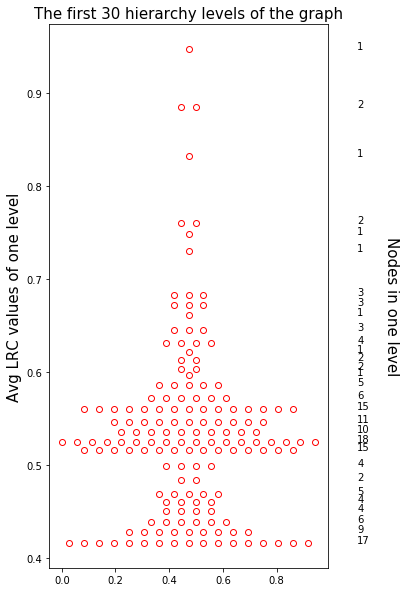

In [14]:
plt.figure(figsize=(5,10))

plt.plot([c[0] for c in coord_G_scf_small],[c[1] for c in coord_G_scf_small],'ro',markerfacecolor='none',alpha=1)

for i in range(nr_lvls):#(len(lvl_avgLRC_mix_undir)):
    plt.text(1.1,lvl_avgLRC_G_scf_small[i],len(lvl_names_G_scf_small[i]))
plt.title('The first 30 hierarchy levels of the graph',fontsize=15)
plt.ylabel('Avg LRC values of one level',fontsize=15)
plt.text(1.2,0.6,'Nodes in one level',rotation=-90,fontsize=15)
plt.show()

# Neighborhood:
#### content of neighborhood.py:

Sometimes it's useful to select the neighbors of one nodes at a strange way.
* Moving by the $in$ or $out$ edges
* Nodes within $n$ steps or exactly $n$ steps
* Selecting only the nodenames in a list
* Or returning their subgraph
* Getting all of above but on a bunch of nodes at the same time

This package contains function for these selections. 
One possible application is the selection of the first order neighbors of some base nodes. Some time ago I needed the environment of some nodes (component), and finding those nodes that are linked to more component, I named the method as **first order neighbors**
* We have a directed graph, with a list of critical nodes (base nodes)
* We don't need the out-neighbors of the basenodes
* The first order nodes can point directly at one and only one base node(one step)
* Or point at a node, that point at one base node (two or more step)
* But they cannot have edges that links them to any other nodes (no outgoing edge besides the previous ones)
* After selecting the first order neighbors, we can find binding nodes, that point at two or more first order component. (binging nodes)

## Example:
* We have two basenode **A**
* The first order neighbors are : **1**,**2**,**3**,**4**,**5**,**6**,**7**,**8**,**9**,**10** and **A** , the **e...some number** are the bad nodes, that we want to filter
* The **e1** is pointed by **A**
* **e2** points at **A** and **3** which is good, but points at **e3** which doesn't have a link to any other first order node
* The same with **e5**, but it points only at **4**

* The **K1** is a binding node:

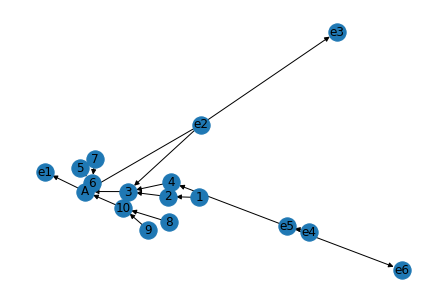

In [5]:
G = nx.DiGraph()

G.add_edges_from([(1,2),(2,3),(4,3),(3,'A'),(5,6),(7,6),(6,'A'),(10,'A'),(8,10),(9,10),
                  ('A','e1'),('e2',3),('e2','A'),('e2','e3')])

# cause chaos:
G.add_edges_from([('e4','e5'),('e5',4),('e5','e6')])

nx.draw(G,with_labels=True)

In [16]:
print('First order neighbors and the binding nodes: (we don\'t have binging nodes with one component:)')
neig.env_of_nodes_first_order(G,basic_nodes=['A'])

First order neighbors and the binding nodes: (we don't have binging nodes with one component:)


([['A', 3, 6, 10, 2, 4, 5, 7, 8, 9, 1]], [])

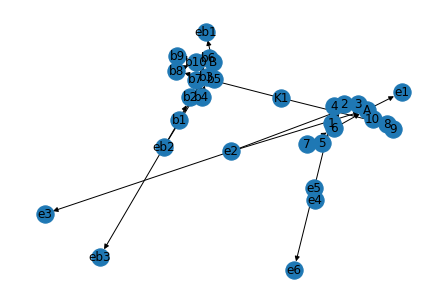

In [17]:
G = nx.DiGraph()

G.add_edges_from([(1,2),(2,3),(4,3),(3,'A'),(5,6),(7,6),(6,'A'),(10,'A'),(8,10),(9,10),
                  ('A','e1'),('e2',3),('e2','A'),('e2','e3')])

G.add_edges_from([('b1','b2'),('b2','b3'),('b4','b3'),('b3','B'),('b5','b6'),('b7','b6'),
                  ('b6','B'),('b10','B'),('b8','b10'),('b9','b10'),
                  ('B','eb1'),('eb2','b3'),('eb2','B'),('eb2','eb3')])

G.add_edges_from([('K1',8),('K1','b8')])

# cause chaos:
G.add_edges_from([('e4','e5'),('e5',4),('e5','e6')])

# G.add_edges_from([(3,'b3'),(6,'b6')])

nx.draw(G,with_labels=True)

In [18]:
print('First order neighbors and the binding nodes:')
neig.env_of_nodes_first_order(G,basic_nodes=['A','B'])

First order neighbors and the binding nodes:


([['A', 3, 6, 10, 2, 4, 5, 7, 8, 9, 1],
  ['B', 'b3', 'b6', 'b10', 'b2', 'b4', 'b5', 'b7', 'b8', 'b9', 'b1']],
 ['K1'])